<a href="https://colab.research.google.com/github/dvnananth/rasmitha/blob/main/FMNIST_CNN_WnB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Step 0: Install WandB if not installed
!pip install -q wandb

In [14]:
# Step 1: Imports
import os
import gzip
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import wandb
import matplotlib.pyplot as plt

In [15]:
# Step 2: Download Fashion-MNIST data (gzipped)
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
DATA_PATH = "/content"

--2026-01-30 06:14:30--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.136.118, 3.5.134.129, 3.5.137.27, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|3.5.136.118|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘train-images-idx3-ubyte.gz’ not modified on server. Omitting download.

--2026-01-30 06:14:30--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.136.118, 3.5.134.129, 3.5.137.27, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|3.5.136.118|:80... connected.
HTTP request sent, aw

In [16]:
# Step 3: Loader function for MNIST IDX files
def load_mnist(path, kind='train'):
    FILE_MAP = {
        'train': ('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz'),
        't10k': ('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')
    }

    images_file, labels_file = FILE_MAP[kind]
    images_path = os.path.join(path, images_file)
    labels_path = os.path.join(path, labels_file)

    # Load labels
    with gzip.open(labels_path, 'rb') as f:
        labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

    # Load images
    with gzip.open(images_path, 'rb') as f:
        images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels


In [17]:
# Step 4: Load datasets
images_train, labels_train = load_mnist(DATA_PATH, 'train')
images_test, labels_test = load_mnist(DATA_PATH, 't10k')

print("Train images:", images_train.shape, "Train labels:", labels_train.shape)
print("Test images:", images_test.shape, "Test labels:", labels_test.shape)


Train images: (60000, 784) Train labels: (60000,)
Test images: (10000, 784) Test labels: (10000,)


In [18]:
# Step 5: Define PyTorch Dataset
class FMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx], dtype=torch.float32).view(1, 28, 28)
        img =img / 255.0
        lbl = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, lbl

traindata = FMNISTDataset(images_train, labels_train)
testdata = FMNISTDataset(images_test, labels_test)

trainloader = DataLoader(traindata, batch_size=128, shuffle=True, num_workers = 2)
testloader = DataLoader(testdata, batch_size=128, num_workers = 2)

In [23]:
# Step 6: Define CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)               # always (B, 64, 1, 1)
        x = torch.flatten(x, 1)       # (B, 64)
        x = self.classifier(x)
        return x

model = SimpleCNN()

In [24]:
# Step 7: Initialize W&B
wandb.init(
    project="fmnist-tutorial",
    name="BetterCNN_CPU",
    config={
        "learning_rate": 0.001,
        "batch_size": 128,
        "conv_channels": [32, 64],
        "dataset": "Fashion-MNIST",
        "kernel_size": 3,
        "epochs": 15,
        "normalization": "BatchNorm"
    }
)
wandb.watch(model, log="parameters", log_freq=500)

In [25]:
# Step 8: Loss and optimizer
#loss_fn = nn.NLLLoss()
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay =1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [26]:
# Step 9: Training loop with W&B logging
epochs = wandb.config.epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(trainloader):

        optimizer.zero_grad(set_to_none=True)

        output = model(data)
        loss = loss_fn(output, target)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item() * data.size(0)

        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

        if batch_idx % 200 == 0:    #batches is 200
            wandb.log({"batch_loss": loss.item(), "epoch": epoch})

    avg_loss = running_loss / len(trainloader.dataset)
    train_acc = 100 * correct / total

    scheduler.step()

    wandb.log({"epoch_loss": avg_loss, "train_accuracy": train_acc, "epoch": epoch})
    print(f"Epoch {epoch} average loss: {avg_loss:.4f} training loss: {train_acc:.2f}%")

Epoch 0 average loss: 1.2727 training loss: 66.87%
Epoch 1 average loss: 1.0006 training loss: 79.06%
Epoch 2 average loss: 0.9348 training loss: 82.37%
Epoch 3 average loss: 0.8985 training loss: 83.95%
Epoch 4 average loss: 0.8756 training loss: 84.98%
Epoch 5 average loss: 0.8421 training loss: 86.55%
Epoch 6 average loss: 0.8315 training loss: 87.05%
Epoch 7 average loss: 0.8225 training loss: 87.53%
Epoch 8 average loss: 0.8151 training loss: 87.94%
Epoch 9 average loss: 0.8085 training loss: 88.22%


In [27]:
# Step 10: Evaluate on test set
def evaluate(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            loss = loss_fn(output, target)

            total_loss += loss.item() * data.size(0)

            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

test_loss, test_acc = evaluate(model, testloader, loss_fn)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

Test Loss: 0.8348, Test Accuracy: 85.89%


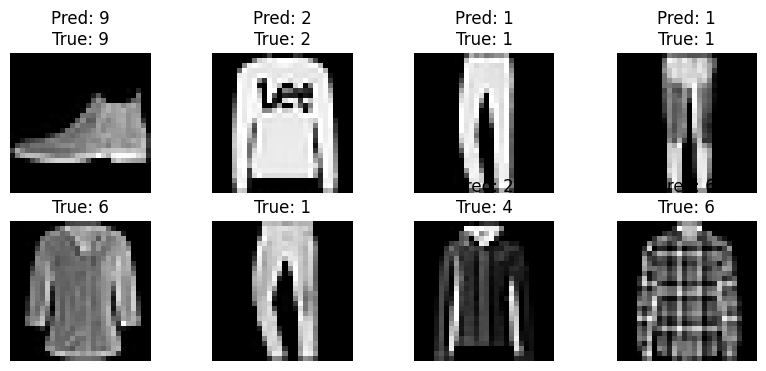

batch_loss,█▃▂▃▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▁▁▁▁▁▁▂▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
epoch_loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▇▇▇████
batch_loss,0.76078
epoch,9
epoch_loss,0.80852
test_accuracy,85.89
test_loss,0.83484


In [28]:
# Step 11: Visualize some test images with predictions
data_iter = iter(testloader)
images, labels = next(data_iter)
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(10,4))
for idx in range(8):
    ax = fig.add_subplot(2,4,idx+1)
    ax.imshow(images[idx].cpu().squeeze(), cmap='gray')
    ax.set_title(f"Pred: {preds[idx].item()}\nTrue: {labels[idx].item()}")
    ax.axis('off')
plt.show()

# Finish W&B run
wandb.finish()